## Merging weather data with delay data to find patterns

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# load weather data
weather_df = pd.read_csv('data/weather_02.csv').drop(columns="Unnamed: 0")
# load flight data for airports for which we have weather data
flights_df = pd.read_csv('data/flights_random_50k_cleaned.csv').drop(columns="Unnamed: 0")
airports = weather_df.airport.unique()
cond = flights_df.origin.isin(airports)
flights_df = flights_df[cond]

In [4]:
flights_df.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
5,2018-11-11,AA,AA,AA,1740,AA,N560UW,1740,11057,CLT,...,307.0,301.0,286.0,1.0,2077.0,0.0,0.0,0.0,0.0,0.0
6,2019-05-19,DL,DL,DL,724,DL,N590NW,724,10397,ATL,...,285.0,278.0,257.0,1.0,1892.0,0.0,0.0,0.0,0.0,0.0
8,2018-08-05,DL,DL,DL,2662,DL,N995AT,2662,14492,RDU,...,110.0,99.0,78.0,1.0,501.0,0.0,0.0,0.0,0.0,0.0
10,2019-05-11,AS,AS,AS,1795,AS,N626VA,1795,12892,LAX,...,155.0,132.0,115.0,1.0,834.0,0.0,0.0,0.0,0.0,0.0
11,2018-08-06,HA,HA,HA,29,HA,N391HA,29,14747,SEA,...,360.0,411.0,351.0,1.0,2640.0,49.0,0.0,0.0,0.0,0.0


In [5]:
weather_df.head()

,airport,date,precip,snow,snowdepth,windgust,cloudcover,icon
0,ATL,2018-01-01,0.0,0.0,0.0,40.7,74.3,partly-cloudy-day
1,ATL,2018-01-02,0.0,0.0,0.0,NaN,29.6,partly-cloudy-day
2,ATL,2018-01-03,0.0,0.0,0.0,29.5,67.1,partly-cloudy-day
3,ATL,2018-01-04,0.0,0.0,0.0,51.8,6.9,wind
4,ATL,2018-01-05,0.0,0.0,0.0,37.1,28.0,partly-cloudy-day


In [6]:
row = flights_df.iloc[int(np.random.rand() * len(flights_df))]

apt = row.dest
date = row.fl_date

c1, c2 = weather_df.airport == apt, weather_df.date == date
w = weather_df[c1 & c2]
if len(w) == 1:
    print(w.iloc[0].icon)
else:
    print(f"Ambiguous: {len(w)} results")
# if len(w) == 1:
#     print(w.iloc[0].weather)

snow


In [7]:
# add origin and destination weather columns

def origin_weather(row):
    apt = row.origin
    date = row.fl_date

    c1, c2 = weather_df.airport == apt, weather_df.date == date
    w = weather_df[c1 & c2]
    if len(w) == 1:
        return w.iloc[0].icon
    else:
        return "unavailable"

def dest_weather(row):
    apt = row.dest
    date = row.fl_date

    c1, c2 = weather_df.airport == apt, weather_df.date == date
    w = weather_df[c1 & c2]
    if len(w) == 1:
        return w.iloc[0].icon
    else:
        return "unavailable"

    
flights_df['origin_weather'] = flights_df.apply(origin_weather, 1)
flights_df['dest_weather'] = flights_df.apply(dest_weather, 1)

In [8]:
flights_df.origin_weather.value_counts()

partly-cloudy-day    4492
rain                 4318
wind                 1258
clear-day            1142
cloudy               1036
unavailable           560
snow                  366
Name: origin_weather, dtype: int64

In [9]:
flights_df.dest_weather.value_counts()

unavailable          11237
partly-cloudy-day      721
rain                   603
wind                   200
clear-day              188
cloudy                 169
snow                    54
Name: dest_weather, dtype: int64

In [10]:
# drop null origin_weather rows
cond = flights_df.origin_weather != "unavailable"
flights_df = flights_df[cond]

In [11]:
flights_df.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,origin_weather,dest_weather
5,2018-11-11,AA,AA,AA,1740,AA,N560UW,1740,11057,CLT,...,286.0,1.0,2077.0,0.0,0.0,0.0,0.0,0.0,partly-cloudy-day,unavailable
6,2019-05-19,DL,DL,DL,724,DL,N590NW,724,10397,ATL,...,257.0,1.0,1892.0,0.0,0.0,0.0,0.0,0.0,partly-cloudy-day,unavailable
8,2018-08-05,DL,DL,DL,2662,DL,N995AT,2662,14492,RDU,...,78.0,1.0,501.0,0.0,0.0,0.0,0.0,0.0,rain,unavailable
10,2019-05-11,AS,AS,AS,1795,AS,N626VA,1795,12892,LAX,...,115.0,1.0,834.0,0.0,0.0,0.0,0.0,0.0,rain,unavailable
11,2018-08-06,HA,HA,HA,29,HA,N391HA,29,14747,SEA,...,351.0,1.0,2640.0,49.0,0.0,0.0,0.0,0.0,partly-cloudy-day,unavailable


In [12]:
flights_df.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled', 'diverted', 'dup',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'origin_weather',
       'dest_weather'],
      dtype='object')

In [13]:
# copy only relevant features
flights_df = flights_df[['fl_date', 'origin', 'dep_delay', 'arr_delay', 'diverted',
       'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'origin_weather', ]].copy()

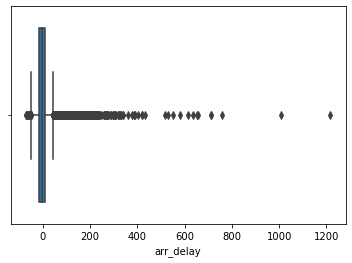

In [14]:
# see distribution for delays
sns.boxplot(x=flights_df.arr_delay)

In [15]:
# function "borrowed" from Robyn
def rem_outliers(df, col):
    ''' Remove outliers which fall outside of 3 standard deviations above and below the mean of the data set
            Input
                (0) dataframe containing the data
                (1) column to remove outliers from
            Output
                rows of df which are classified as outliers in the specified column are directly removed
                print out stating count of outliers removed '''
    mean, cutoff = np.mean(df[col]), np.std(df[col]) * 3   # 3 stddev outside the mean
    lower, upper = mean - cutoff, mean + cutoff
    outliers = [x for x in df[col] if x < lower or x > upper]
    df.drop(df[(df[col] > upper) | (df[col] < lower)].index, inplace=True)
    return f'{len(outliers)} outliers removed'

In [16]:
rem_outliers(flights_df, 'arr_delay')

'225 outliers removed'

Text(0.5, 0, 'Arrival delay')

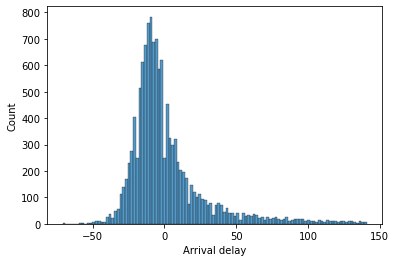

In [17]:
# see distribution for delays again
ax = sns.histplot(x=flights_df.arr_delay)
ax.set_xlabel("Arrival delay")

Text(0, 0.5, 'Arrival delay')

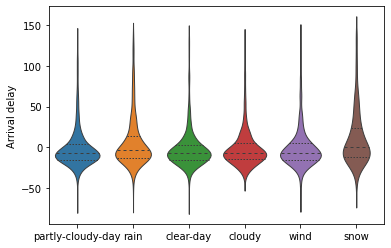

In [18]:
x = flights_df.origin_weather.to_numpy()
y = flights_df.arr_delay.to_numpy()

ax = sns.violinplot(x=x, y=y, split=True, inner="quart", linewidth=1)
ax.set_ylabel("Arrival delay")

Based on raw correlation, weather doesn't significantly affect the arrival delay. However, snow seems to have a significant effect on the variance. I'll dig a little deeper.

In [19]:
weather_dummies = pd.get_dummies(flights_df.origin_weather, prefix='or_weather')

In [20]:
flights_df = pd.concat([flights_df, weather_dummies], axis=1)

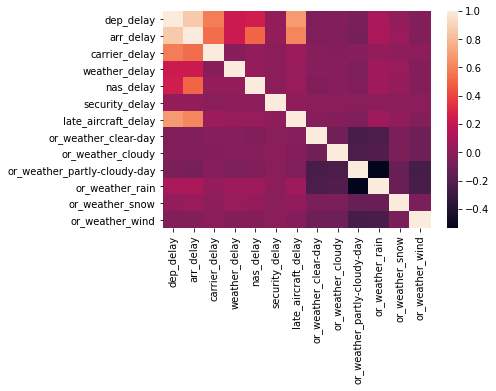

In [21]:
df_num = flights_df[['dep_delay', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'or_weather_clear-day', 'or_weather_cloudy', 'or_weather_partly-cloudy-day', 'or_weather_rain',
       'or_weather_snow', 'or_weather_wind']]

sns.heatmap(df_num.corr())

## Narrow in on "extreme weather" 

In [105]:
df_weather = pd.read_csv('data/weather_03.csv').drop(columns="Unnamed: 0")
df_flights = pd.read_csv('data/flights_for_weather.csv').drop(columns='Unnamed: 0')

/home/omlean/anaconda3/envs/lighthouse/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [106]:
df_weather['windgust'] = df_weather['windgust'].fillna(value=0)

In [107]:
rem_outliers(df_flights, 'arr_delay')

'69979 outliers removed'

In [108]:
cols = ['fl_date', 'origin_airport_id', 'origin', 'dest_airport_id', 'dest',
        'crs_dep_time', 'dep_time', 'dep_delay', 'arr_delay', 'cancelled',
        'cancellation_code', 'diverted', 'carrier_delay', 'weather_delay', 
        'nas_delay', 'security_delay', 'late_aircraft_delay']
df_flights = df_flights[cols]
for col in ['cancellation_code', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']:
    df_flights[col] = df_flights[col].fillna(value=0)


# make groupby
median_delays = df_flights.groupby(['origin', 'fl_date']).median().arr_delay

find quantiles that give the best prediction of delays

In [109]:
def median_delay(row):
    apt = row.airport
    date = row.date
    try:
        return median_delays[apt, date]
    except KeyError:
        return np.nan

df_weather['median_out_delay'] = df_weather.apply(median_delay, axis=1)
# mean_out_delay is the mean ultimate (arrival) delay of outgoing flights from that airport on that day

In [110]:
df_weather.head()

,airport,date,precip,snow,snowdepth,windgust,cloudcover,icon,median_out_delay
0,ATL,2018-01-01,0.0,0.0,0.0,40.7,74.3,partly-cloudy-day,-3.0
1,ATL,2018-01-02,0.0,0.0,0.0,0.0,29.6,partly-cloudy-day,-4.0
2,ATL,2018-01-03,0.0,0.0,0.0,29.5,67.1,partly-cloudy-day,-6.0
3,ATL,2018-01-04,0.0,0.0,0.0,51.8,6.9,wind,-7.0
4,ATL,2018-01-05,0.0,0.0,0.0,37.1,28.0,partly-cloudy-day,-6.0


(array([3.100e+01, 2.090e+02, 8.130e+02, 2.851e+03, 1.581e+03, 3.630e+02,
        1.670e+02, 6.200e+01, 3.400e+01, 3.500e+01, 1.400e+01, 1.000e+01,
        1.000e+01, 5.000e+00, 6.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00]),
 array([-27.5  , -21.675, -15.85 , -10.025,  -4.2  ,   1.625,   7.45 ,
         13.275,  19.1  ,  24.925,  30.75 ,  36.575,  42.4  ,  48.225,
         54.05 ,  59.875,  65.7  ,  71.525,  77.35 ,  83.175,  89.   ]),
 <a list of 20 Patch objects>)

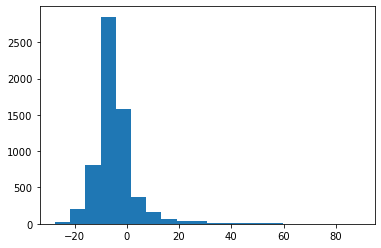

In [111]:
plt.hist(df_weather.median_out_delay, bins=20)

In [112]:
def percentile(series, perc=5):
    div = 100/perc
    return series.sort_values(ascending=False).reset_index(drop=True)[int(len(series)/div)]

def is_extreme(series, perc=5):
    return (series >= percentile(series, perc=perc)).astype(int)

df_weather['extreme_precip'] = is_extreme(df_weather.precip)
df_weather['extreme_snow'] = is_extreme(df_weather.snow, 0.1)
df_weather['extreme_windgust'] = is_extreme(df_weather.windgust, 5)
df_weather['extreme_cloudcover'] = is_extreme(df_weather.cloudcover, 5)

In [113]:
df_weather.head()

,airport,date,precip,snow,snowdepth,windgust,cloudcover,icon,median_out_delay,extreme_precip,extreme_snow,extreme_windgust,extreme_cloudcover
0,ATL,2018-01-01,0.0,0.0,0.0,40.7,74.3,partly-cloudy-day,-3.0,0,0,0,0
1,ATL,2018-01-02,0.0,0.0,0.0,0.0,29.6,partly-cloudy-day,-4.0,0,0,0,0
2,ATL,2018-01-03,0.0,0.0,0.0,29.5,67.1,partly-cloudy-day,-6.0,0,0,0,0
3,ATL,2018-01-04,0.0,0.0,0.0,51.8,6.9,wind,-7.0,0,0,0,0
4,ATL,2018-01-05,0.0,0.0,0.0,37.1,28.0,partly-cloudy-day,-6.0,0,0,0,0


# Random Forest Regressor 1

In [114]:
X = df_weather[['extreme_precip', 'extreme_snow',
                'extreme_windgust', 'extreme_cloudcover']].to_numpy()
y = df_weather.median_out_delay.to_numpy()

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [116]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor()

In [117]:
rf.feature_importances_

array([0.7522537 , 0.10402844, 0.07947767, 0.06424019])

In [118]:
y_pred = rf.predict(X_test)

In [119]:
r2_score(y_test, y_pred)

0.08717692719300707

I'll try with the original weather columns

In [120]:
X = df_weather[['precip', 'snow', 'windgust', 'cloudcover']].to_numpy()
y = df_weather.median_out_delay.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [121]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor()

In [122]:
y_pred = rf.predict(X_test)
r2_score(y_test, y_pred)

0.15491755281972097

In [123]:
rf.feature_importances_

array([0.35449222, 0.11277057, 0.21867988, 0.31405733])

Now let's try plugging the weather data back into the original flights data

In [124]:
df_flights = pd.read_csv('data/flights_for_weather.csv').drop(columns='Unnamed: 0')
rem_outliers(df_flights, 'arr_delay')

/home/omlean/anaconda3/envs/lighthouse/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


'69979 outliers removed'

In [ ]:
c1 = df.arr_time.notnull()
c2 = df.arr_delay.notnull()
df = df[c1 & c2]

#  same with dep_delay
c3 = df.dep_time.notnull()
c4 = df.dep_delay.notnull()
df = df[c3 & c4]